# Implementing PVI on logistic regression with a single client for more interesting data. This example is modified from Ashman et al. (2022), but extended during this project, and we compare it with a Support Vector Machine result.

In [1]:
%load_ext autoreload
%autoreload 2


import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pvi.models import LogisticRegressionModel
from pvi.clients import Client
from pvi.distributions import MultivariateGaussianDistribution
from pvi.distributions import MultivariateGaussianFactor


import torch
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

from torch import nn

%matplotlib inline
torch.set_default_dtype(torch.float64)

# Set up data and helper functions

In [24]:
# More interesting Data set: from A first course in machine learning
# Generate some data
trainx = np.vstack((np.random.randn(50,2),np.random.randn(50,2)+4))
trainy = np.hstack((-1*np.ones(50,),np.ones(50,)))[:,None]

tx = torch.tensor(trainx)
ty = torch.tensor(trainy)

ty[ty == -1] = 0

# Uncomment this if you want to add noise (last bit of exercise)
for i in range(3):
    pos = np.random.randint(50)
    if trainy[pos] == -1:
        trainy[pos] = 1
    else:
        trainy[pos] = -1

#Rescaling the dataset:
x_mu = 0.
y_mu = 0.
for i in range(len(ty)):
    x_mu = x_mu + tx[i][0]
    y_mu = y_mu + tx[i][1]

mu = torch.tensor([[x_mu/100, y_mu/100]])

In [25]:
#Rescaling all points around the total mean point
for i in range(len(ty)):
    temp_x = tx[i][0] - mu[0][0]
    temp_y = tx[i][1] - mu[0][1]
    tx[i][0] = temp_x
    tx[i][1] = temp_y

In [26]:
# keyword b deprecated, use visible instead
def plot_data(x, y):
    x_vals = x[:, 0]
    y_vals = x[:, 1]
    labels = y
    
    plt.figure()
    plt.grid(visible=True)
    plt.scatter(x_vals, y_vals, c=labels)
    plt.show()

def plot_results(x, y, client, q):
    x_vals = x[:, 0]
    y_vals = x[:, 1]
    labels = y
    
    q_np1 = q.nat_params["np1"]
    q_np2 = q.nat_params["np2"]
    w_map = (-2 * q_np2).inverse().matmul(q_np1).detach()
    
    plt.figure()
    plt.grid(visible=True)
    plt.scatter(x_vals, y_vals, c=labels)
    plt.arrow(0, 0, w_map[0], w_map[1], head_width=0.1)
    plt.plot([-2, 2], [(w_map[0]/w_map[1])*2, (w_map[0]/w_map[1])*-2])
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
def plot_data_with_line(x, y, xs, ys):

    x_vals = x[:, 0]
    y_vals = x[:, 1]
    labels = y
    
    plt.figure()
    plt.grid(visible=True)
    plt.scatter(x_vals, y_vals, c=labels)
    
    #Plotting the line between the two points
    plt.plot(xs, ys, color="black", linewidth=.75)   
    plt.show()
    
data = {
    "x": tx,
    "y": ty,   
}

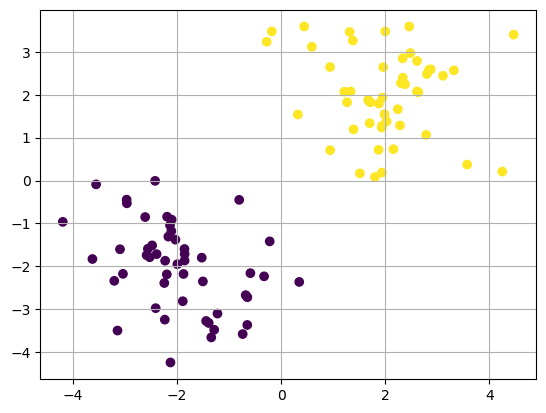

In [27]:
assert len(trainx) == len(trainy), "Different sizes"
plot_data(tx, ty)

# Construct logistic regression model

In [28]:
model_config = {
    "D": 2,
}

model = LogisticRegressionModel(config=model_config)

q = MultivariateGaussianDistribution(
    std_params={
        "loc": torch.zeros(model_config["D"] + 1),
        "covariance_matrix": torch.eye(model_config["D"] + 1)
    },
    is_trainable=True,
)

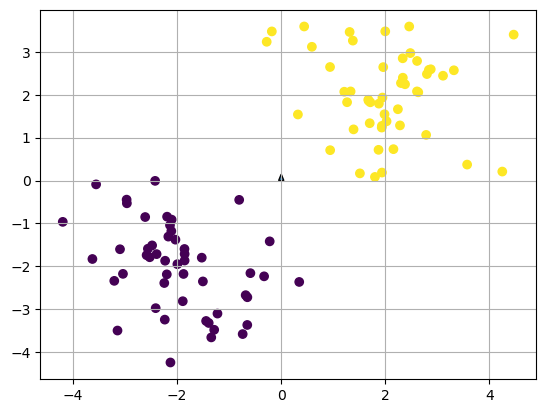

In [29]:
plot_results(tx, ty, model, q)

# Fit data

In [30]:
t = MultivariateGaussianFactor(
    nat_params = {
        "np1": torch.zeros(model.config["D"] + 1),
        "np2": 0. * torch.eye(model.config["D"] + 1)
    }
)

In [31]:
client_config = {
    "optimiser": "Adam",
    "optimiser_params": {"lr": 1e-3},
    "epochs": 4000,
    "batch_size": 100,
    "num_elbo_samples": 100,
    "num_predictive_samples": 1
}

In [32]:
client = Client(data=data, model=model, t=t, config=client_config)

## Without optimising model (hyper-)parameters

In [33]:
q_new, t_new = client.update_q(q)

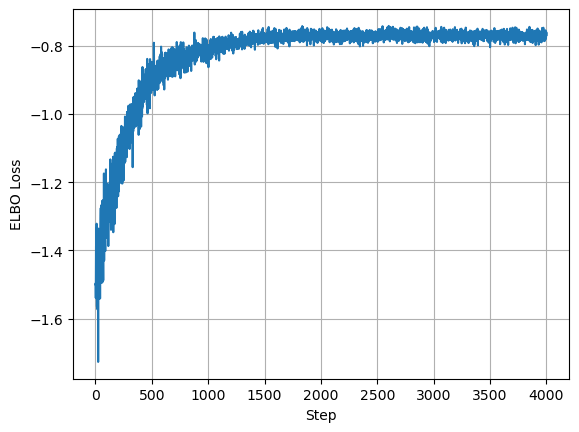

In [34]:
plot_training(client.log["training_curves"][0]["elbo"])

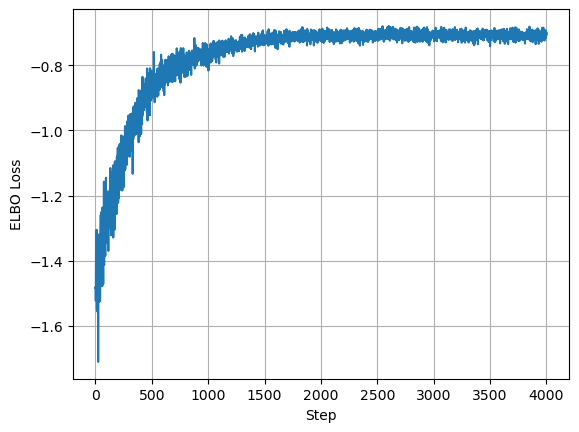

In [35]:
plot_training(client.log["training_curves"][0]["ll"])

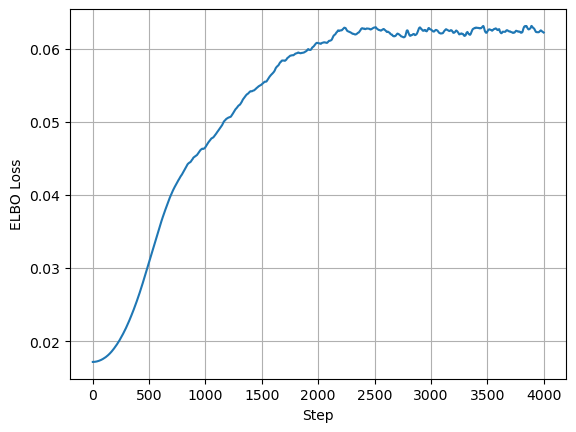

In [36]:
plot_training(client.log["training_curves"][0]["kl"])

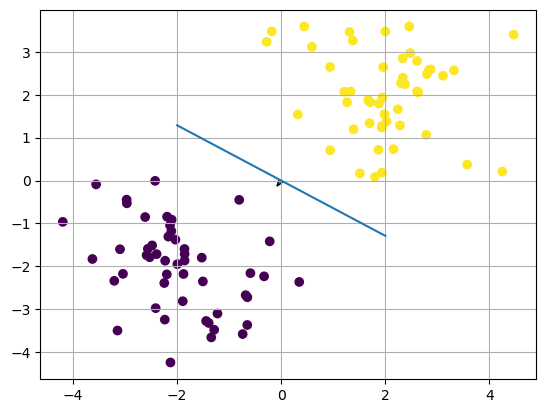

In [37]:
plot_results(tx, ty, model, q_new)

### Comparing the PVI method for linear separation of data, which is possible with the simplest example being the line y = x, hence we compare the results of PVI with the results of a Support Vector Machine.

In [38]:
#Linear SVM implementation without kernel methods:
#we set Y == 0, ie. class 1, to be negative and the rest to be of positive sign
y_new = np.where(ty == 0, -1, 1)
y_ = []
for e in y_new:
    temp = e[0]
    y_.append(temp)
    
assert len(y_new) == len(y_)

#No prior knowledge about w or b
w = np.zeros(2) 
b = 0 

lr = 0.001
lambda_param = 0.01

#For 100 iterations, we check all input data points and see if they fulfill the condition (np.dot(x_i, w) - b) 
# correctly classifies x_i, if it does we aim to maximise w, if it doesn't we adjust w and b by the sign of y_i 
for _ in range(1000):
    for idx, x_i in enumerate(tx):
        condition = y_new[idx] * (np.dot(x_i, w) - b) >= 1
        if condition:
            w -= lr * (2 * lambda_param * w)
        else:
            w -= lr * (2 * lambda_param * w - np.dot(x_i, y_[idx]))
            b -= lr * y_[idx]

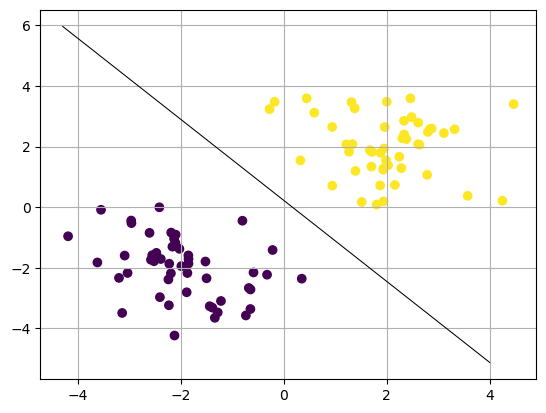

In [43]:
#Gradient of the function
m = - w[0]/w[1]
#Added constant
c = b/w[1]

#inputs xs
xs = np.array([-4.3,4])

#ys as specifies by the function
y_1 = m*(xs[0]) + c
y_2 = m*(xs[1]) + c
ys = np.array([y_1, y_2])

plot_data_with_line(tx, ty, xs, ys)


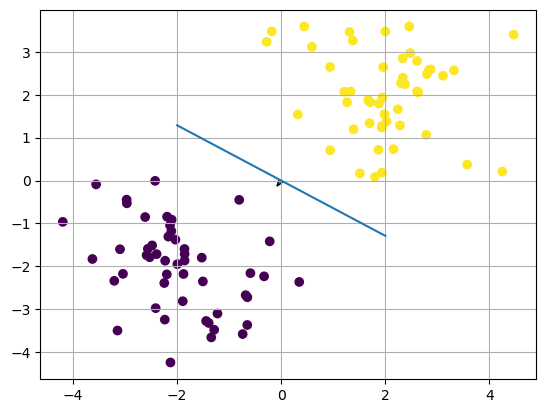

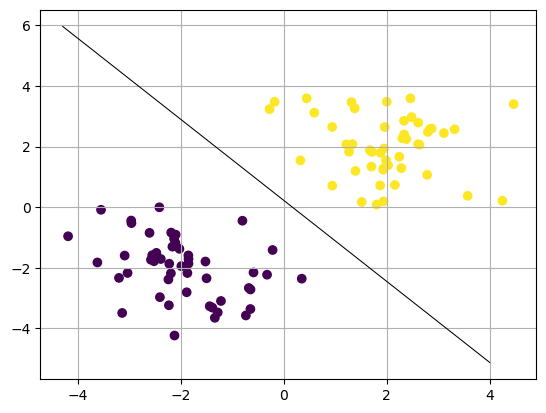

In [44]:
plot_results(tx, ty, model, q_new)
plot_data_with_line(tx, ty, xs, ys)